<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/epfl_building_footprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rooftop detection
We use the data from [Cadei et al - Detecting available rooftop area from satellite images to install photovoltaic panels](https://github.com/riccardocadei/photovoltaic-detection/tree/main) to implement a semantic segmentation model for the extraction of building footprints from satellite images.

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
cd /content/drive/MyDrive/EPFL_Building_Footprints/data/all

/content/drive/.shortcut-targets-by-id/1iI1BCISUNA2rFEKBXNV6SD_pTBTlXqv9/data/all


In [4]:
ls

test/  train/  val/


In [5]:
cd train/images

/content/drive/.shortcut-targets-by-id/1iI1BCISUNA2rFEKBXNV6SD_pTBTlXqv9/data/all/train/images


In [6]:
ls |wc -l

420


In [24]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import io
from skimage import exposure
from skimage.io import imsave, imread
import warnings
warnings.filterwarnings('ignore')


In [35]:
p = Path('/content/drive/MyDrive/EPFL_Building_Footprints/data/all/train/')
paths = []
[paths.append(sub_folder) for sub_folder in p.iterdir() if sub_folder.is_dir()]

[None, None]

In [37]:
p

PosixPath('/content/drive/MyDrive/EPFL_Building_Footprints/data/all/train/labels')

In [51]:
def create_list(raster_path):
    """
    This function extracts the raster file paths (png images or masks) in the
    folder path and puts them in a list. The list is sorted in order to have
    each image and mask with the same index
    """
    img_list = []
    for file in os.listdir(raster_path):
        if file.endswith(".png"):
            img_list.append(os.path.join(raster_path, file))

    return sorted(img_list)

In [39]:
footprints_list = create_list('/content/drive/.shortcut-targets-by-id/1iI1BCISUNA2rFEKBXNV6SD_pTBTlXqv9/data/all/train/images')
len(footprints_list)

420

In [40]:
print(footprints_list[0])

/content/drive/.shortcut-targets-by-id/1iI1BCISUNA2rFEKBXNV6SD_pTBTlXqv9/data/all/train/images/DOP25_LV03_1301_11_2015_1_15_497500.0_119062.5.png


In [41]:
img_0 = io.imread(footprints_list[0])
img_0.shape

(250, 250, 3)

In [43]:
def plot_raster(ax, list_images):
  index = 0
  for col in range(0, fig_cols):
    for row in range(0, fig_rows):
      img_natcol = io.imread(list_images[index])
      img_equalized = exposure.equalize_hist(img_natcol)
      ax[row, col].set_axis_off()
      ax[row, col].imshow(img_equalized)
      index += 1

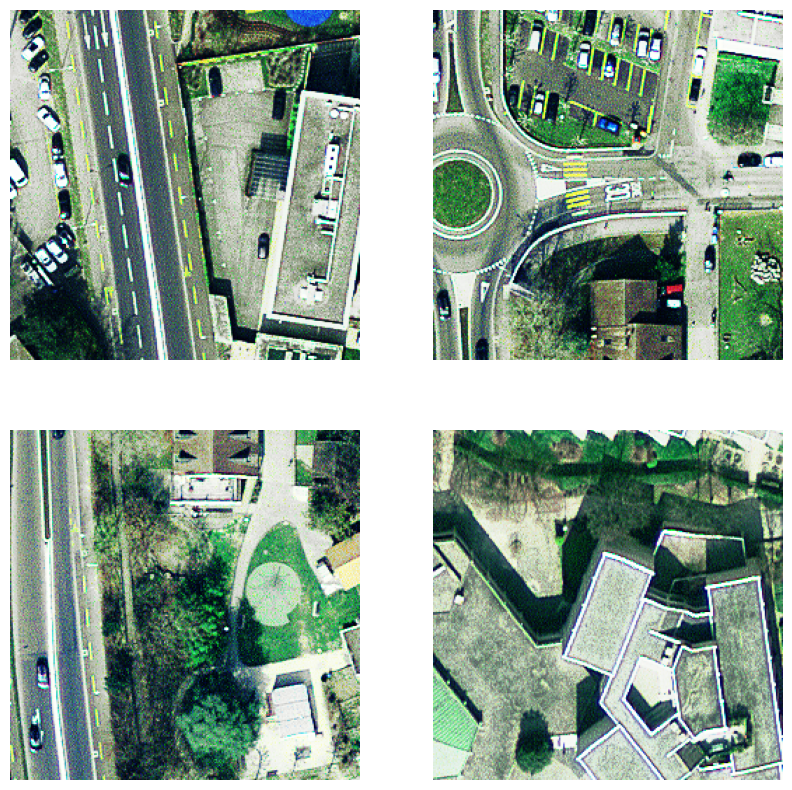

In [44]:
fig_rows = 2
fig_cols = 2
fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
plot_raster(ax, footprints_list)


In [45]:
labels_list = create_list('/content/drive/.shortcut-targets-by-id/1iI1BCISUNA2rFEKBXNV6SD_pTBTlXqv9/data/all/train/labels')
len(labels_list)

420

In [46]:
print(labels_list[0])

/content/drive/.shortcut-targets-by-id/1iI1BCISUNA2rFEKBXNV6SD_pTBTlXqv9/data/all/train/labels/DOP25_LV03_1301_11_2015_1_15_497500.0_119062.5_label.png


In [47]:
label_0 = io.imread(labels_list[0])
label_0.shape

(250, 250, 3)

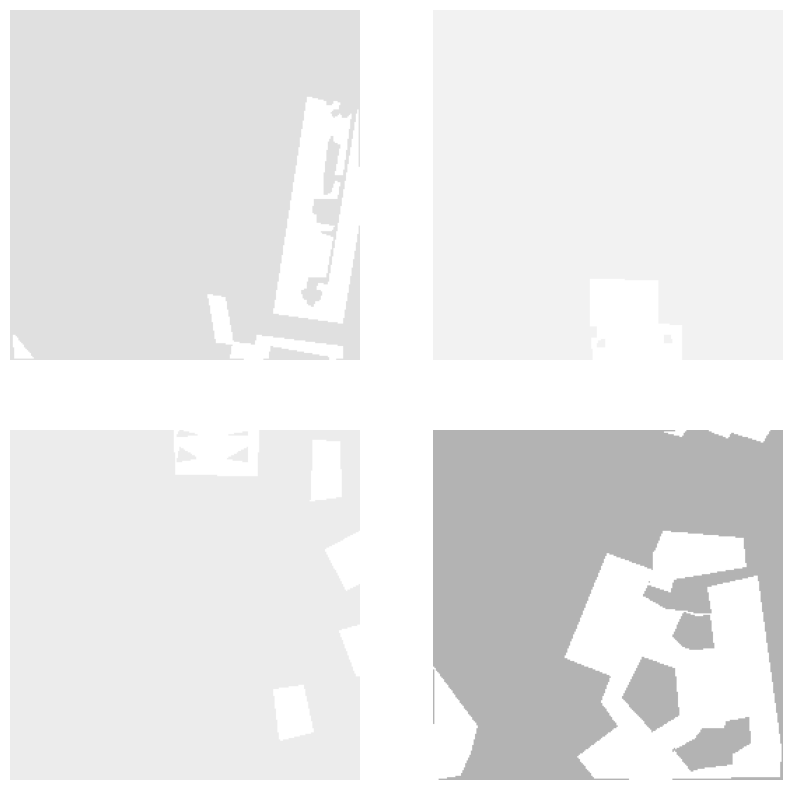

In [48]:
fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
plot_raster(ax, labels_list)